In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
# PATH should point to repository folder
PATH = "/content/drive/My Drive/cpath_robustness"
sys.path.append(PATH)

In [3]:
# Load model
import torch
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchvision import models
import os

def load_resnet(model_path, n_classes=2, pretrained=True, device="cuda:0"):
  model = models.resnet18(pretrained=pretrained)

  model.fc = nn.Sequential(
                        nn.Linear(512, n_classes),
                        nn.LogSoftmax(dim=1))
  
  model.load_state_dict(torch.load(model_path))
  
  model.to(device)
  model.eval()
  return model

model_names = ["std_pre_std_train.pt", "std_pre_std_train_adv_free_retrain_ce_lr_0_02_margin_0_1"]
model_path = os.path.join(PATH, "Models/" + model_names[0])
model = load_resnet(model_path)

In [4]:
# Create test dataset and dataloaders
import os
import numpy as np
from skimage.transform import resize
from PIL import Image

def get_dataloader(dataset, n=100, batch_size=8, num_workers=2, shuffle=False):
  if n is None or n > len(dataset):
    n = len(dataset)
  X_y = dataset[:n]
  X = X_y[0]
  y = X_y[1]
  predict_data = torch.utils.data.TensorDataset(X, y)
  return torch.utils.data.DataLoader(predict_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

DATAPATH = os.path.join(PATH, "Data/breast_folds.npz")

F = np.load(DATAPATH, allow_pickle=True)['F']
len(F)

Xts=[]
yts=[]
ts_counts=[]  

# Test data
images, counts =F[0]
for i in range(len(counts)):
  cc = counts[i]
  if cc[0] >= 5:    
    yts.append(1)    
  elif cc[0] == 0:
    yts.append(0)
  else:
    continue
    
  ts_counts.append(cc[0])
  im = Image.fromarray(np.uint8(images[i]))
  Xts.append(np.transpose(np.array(im.resize( (224, 224))),(2,0,1)))

Xts = np.array(Xts)
yts = np.array(yts)
ts_counts = np.array(ts_counts)

Xts = torch.FloatTensor(Xts)
yts = torch.LongTensor(yts)

test_dataset = torch.utils.data.TensorDataset(Xts, yts)

batch_size = 8
small_loader = get_dataloader(test_dataset, n=100, batch_size=batch_size)
big_loader = get_dataloader(test_dataset, n=1000, batch_size=batch_size)
full_loader = get_dataloader(test_dataset, n=None, batch_size=batch_size)

In [5]:
# Import toolbox
from transforms import Transform, PixelTransform, StainTransform
from attacks import Attack, PGD
from evaluator import Evaluator

In [6]:
# Create some useful functions for plotting results
import matplotlib.pyplot as plt

def plot_change(param_values, all_scores, xlabel="", ylabel="", title="", x_range=None, y_range=None, y_ticks=None):
  fig = plt.figure()
  plot = sns.lineplot(x=param_values, y=all_scores)
  plot.set_xlabel(xlabel)
  plot.set_ylabel(ylabel)
  plot.set_title(title) 
  if x_range is not None:
    plot.set(xlim=x_range)
  if y_range is not None:
    plot.set(ylim=y_range)
  if y_ticks is not None:
    plot.set(yticks=y_ticks)     
  return fig

def display_results(input, adv_input, classes):
  in_out = model(input.unsqueeze(0))
  adv_out = model(adv_input.unsqueeze(0))

  in_index = torch.argmax(in_out).item()
  adv_index = torch.argmax(adv_out).item()

  in_class = classes[in_index]
  adv_class = classes[adv_index]

  in_conf = round(torch.exp(in_out)[0][in_index].item() * 100, 1)
  adv_conf = round(torch.exp(adv_out)[0][adv_index].item() * 100, 1)

  perturbation = adv_input - input

  fig = plt.figure(figsize=[13, 9])

  input = input.permute(1,2,0).detach().cpu().numpy()
  adv_input = adv_input.permute(1,2,0).detach().cpu().numpy()
  perturbation = perturbation.permute(1,2,0).detach().cpu().numpy()

  plt.subplot(1, 3, 1)
  plt.imshow(input.astype(int))
  plt.title(in_class + ", " + str(in_conf) + "% confidence")
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])

  plt.subplot(1, 3, 2)
  rmse = np.sqrt(np.mean(np.power(perturbation, 2)))
  l_inf = np.max(np.abs(perturbation))

  min_val = np.min(np.abs(perturbation))
  max_val = np.max(np.abs(perturbation))
  if min_val < 1 and min_val != max_val:
    perturbation -= np.min(perturbation)
    scale_factor = 255/np.max(perturbation)
    perturbation *= scale_factor
  else:
    scale_factor = 1.0
    perturbation = np.abs(perturbation)
  plt.imshow(perturbation.astype(int))
  plt.title(f'Perturbation - scale factor: {scale_factor:.3f}')
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])
  x_lab = f"L2: {rmse:.3f}, L infinity: {l_inf:.3f}"
  plt.xlabel(x_lab)    

  plt.subplot(1, 3, 3)
  plt.imshow(adv_input.astype(int))
  plt.title(adv_class + ", " + str(adv_conf) + "% confidence")
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])

  return fig

In [7]:
# Define some metrics - these take the results of Evaluator.predict() and 
# compute a single score
from sklearn.metrics import accuracy_score
import seaborn as sns

def accuracy(results):
  labels = results["labels"]
  outputs = results["outputs"]
  _, predictions = torch.max(outputs, 1)
  return accuracy_score(labels, predictions)

def adversarial_accuracy(results):
  labels = results["labels"]
  outputs = results["adversarial_outputs"]
  _, predictions = torch.max(outputs, 1)
  return accuracy_score(labels, predictions)

def rmse(a):
  return torch.sqrt(torch.mean(torch.pow(a, 2)))

def input_sensitivity(results):
  outputs = torch.exp(results["outputs"])
  adv_outputs = torch.exp(results["adversarial_outputs"])
  mean_out_diff = torch.mean(torch.abs(outputs - adv_outputs))
  # print(mean_out_diff.item())
  return mean_out_diff.item()

def normalised_input_sensitivity(results):
  in_sens = input_sensitivity(results)

  pert_measures = results["perturbation_measures"]
  avg_pert = torch.mean(pert_measures)

  norm_in_sens = in_sens / avg_pert
  # print(norm_in_sens.item())  
  return norm_in_sens.item()

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ["Negative", "Positive"]
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [9]:
# Create an Evaluator object using the PixelTransform and the PGD optimiser
# Define the attack parameters
pixel_attack_params = {
    "epsilon": 0.1,
    "steps": 10,
    "constraint": "l2",
    "C": 2,
    "input_range": (0, 255)
}
# Define the transform parameters
pixel_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}
# Create the evaluator - it requires a model, a dataset, a dataloader, an
# optimiser class, a transform class, parameters for the attack and the
# transform, and the desired device (cpu, cuda:0, etc.)
pixel_evaluator = Evaluator(model, test_dataset, small_loader, PGD, PixelTransform, pixel_attack_params, pixel_trans_params, device=device)

In [10]:
# Compute the results using the evaluator
results = pixel_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
# Compute some metrics using the results
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy: 0.93, robust accuracy: 0.0, input sensitivity: 0.878, normalised input sensitivity: 0.439


Starting hyperparameters: {'epsilon': 0.1, 'steps': 10, 'constraint': 'l2', 'C': 0.0, 'input_range': (0, 255)}
0% complete...
23% complete...
46% complete...
69% complete...
92% complete...
Done.


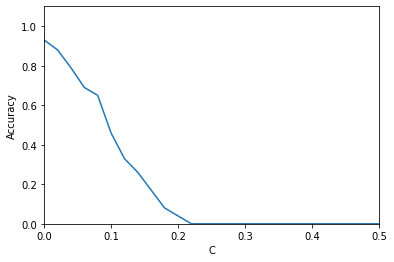

In [11]:
# Choose an attack parameter
param = "C"
# Choose a range of values
param_range = (0, 0.5)
# Choose the step size - the metric will be computed at each value of the 
# parameter
step_size = 0.02
# Choose a metric
metric = adversarial_accuracy
# Use the evaluator to compute the metric over the range of parameter values
# Set the kwargs to compute the correct set of results for the metric - in this
# case we need to adversarially perturb the images, so we set adversarial to
# True
param_values, all_scores = pixel_evaluator.metric_vs_strength(param, param_range, step_size, metric, adversarial=True)
# Use the helper function to plot the scores against the parameter values
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1), y_ticks=y_ticks)

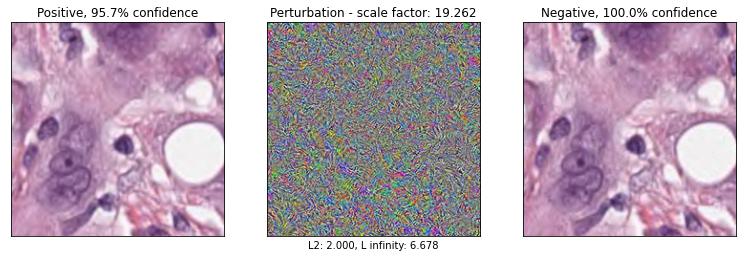

In [12]:
# Get the perturbed inputs directly from the evaluator by passing a list of
# dataset indices
inputs, adv_inputs = pixel_evaluator.attack_inputs([0])
# Use the helper function to display the original inputs, the difference between
# the original and perturbed inputs, and the perturbed inputs
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)

Starting hyperparameters: {'epsilon': 0.02, 'steps': 0, 'constraint': 'l2', 'C': 2, 'input_range': (0, 255)}
0% complete...
27% complete...
55% complete...
82% complete...
Done.


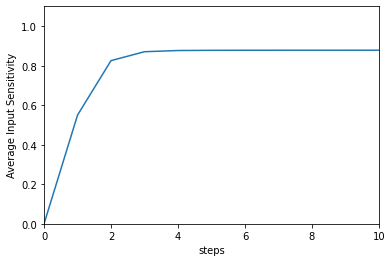

In [13]:
# Set some different hyperparameters for this experiment using a method of
# the evaluator object
new_pixel_attack_params = {
    "epsilon": 0.02,
    "steps": 10,
    "constraint": "l2",
    "C": 2,
    "input_range": (0, 255)
}
pixel_evaluator.set_attack_hyperparameters(new_pixel_attack_params)
# Choose a different attack parameter
param = "steps"
# Choose a range of values
param_range = (0, 10)
# Choose the step size - the metric will be computed at each value of the 
# parameter
step_size = 1
# Choose a different metric
metric = input_sensitivity
# Use the evaluator to compute the metric over the range of parameter values
# Set the kwargs to compute the correct set of results for the metric - we need 
# to compute a measure of the size of the perturbations, so we pass a function 
# handle that computes the rmse of the perturbation
param_values, all_scores = pixel_evaluator.metric_vs_strength(param, param_range, step_size, metric, adversarial=True, perturbation_measure=rmse)
# Use the helper function to plot the scores against the parameter values bjbv 
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Average Input Sensitivity", x_range=param_range, y_range=(0, 1.1), y_ticks=y_ticks)

In [14]:
# Repeat for another transform
stain_attack_params = {
    "epsilon": 0.002,
    "steps": 10,
    "constraint": "l2",
    "C": 0.2,
    "input_range": (0, 255)
}

stain_trans_params = {
    "input_range": (0, 255)
}

stain_evaluator = Evaluator(model, test_dataset, small_loader, PGD, StainTransform, stain_attack_params, stain_trans_params, device=device)

In [15]:
results = stain_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

Accuracy: 0.93, robust accuracy: 0.42, input sensitivity: 0.462, normalised input sensitivity: 0.045


Starting hyperparameters: {'epsilon': 0.002, 'steps': 10, 'constraint': 'l2', 'C': 0.0, 'input_range': (0, 255)}
0% complete...
23% complete...
46% complete...
69% complete...
92% complete...
Done.


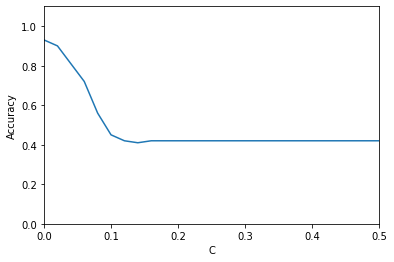

In [16]:
param = "C"
param_range = (0, 0.5)
step_size = 0.02
param_values, all_scores = stain_evaluator.metric_vs_strength(param, param_range, step_size, adversarial_accuracy, adversarial=True)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1), y_ticks=y_ticks)

Starting hyperparameters: {'epsilon': 0.0, 'steps': 10, 'constraint': 'l2', 'C': 0.2, 'input_range': (0, 255)}
0% complete...
24% complete...
48% complete...
71% complete...
95% complete...
Done.


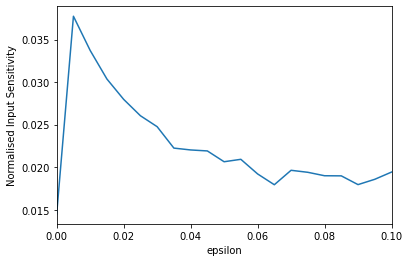

In [25]:
param = "epsilon"
param_range = (0, 0.1)
step_size = 0.005

param_values, all_scores = stain_evaluator.metric_vs_strength(param, param_range, step_size, normalised_input_sensitivity, adversarial=True, perturbation_measure=rmse)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Normalised Input Sensitivity", x_range=param_range)

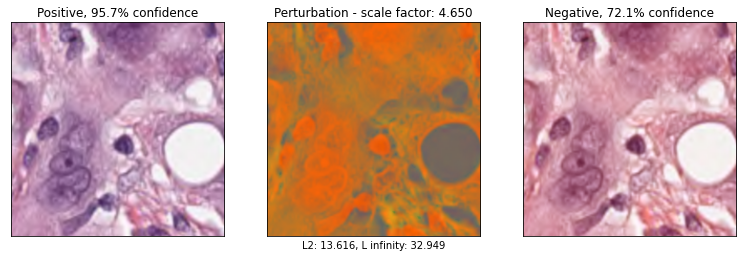

In [18]:
inputs, adv_inputs = stain_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)

In [19]:
# Create a new transform
from torch.autograd import Variable

class MeanTransform(Transform):
    # The class inherits from the abstract class Transform
    def __init__(self, input_shape, device, input_range=(0, 255), noise_range=(-0.1, 0.1)):
        # This method must take input_shape and device and input, and can 
        # optionally take any other desired arguments
        super().__init__(input_shape, device)
        self.input_range = input_range
        batch_size = input_shape[0]
        shape = (batch_size, 1)
        # self.base_weights defines the base perturbation from which to measure
        # the magnitude of the perturbation. Often it will be a tensor of zeros
        self.base_weights = torch.zeros(shape).to(device)
        # self.weights is a tensor with a grad function that will be optimised
        # using the provided optimiser to cause misclassification
        weights = torch.FloatTensor(*shape).uniform_(*noise_range).to(device)
        self.weights = Variable(weights, requires_grad=True).to(device)

    def forward(self, x):
        # This must perform a differentiable (with respect to self.weights) 
        # transform on the inputs x. The transform is parameterised by 
        # self.weights
        for i in range(self.input_shape[0]):
            x[i] = torch.clamp(x[i] + self.weights[i], *self.input_range)
        return x

In [20]:
# Create an evaluator using our new transform
mean_attack_params = {
    "epsilon": 0.5,
    "steps": 20,
    "constraint": "l2",
    "C": 30,
    "input_range": (0, 255)
}

mean_trans_params = {
    "input_range": (0, 255),
    "noise_range": (-0.2, 0.2)
}

mean_evaluator = Evaluator(model, test_dataset, small_loader, PGD, MeanTransform, mean_attack_params, mean_trans_params, device=device)

In [21]:
results = mean_evaluator.predict(adversarial=True, perturbation_measure=rmse, weight_measure=rmse)
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
in_sens = input_sensitivity(results)
norm_in_sens = normalised_input_sensitivity(results)
print(f"Accuracy: {acc}, robust accuracy: {robust_acc}, input sensitivity: {in_sens:.3f}, normalised input sensitivity: {norm_in_sens:.3f}")

Accuracy: 0.93, robust accuracy: 0.85, input sensitivity: 0.071, normalised input sensitivity: 0.003


Starting hyperparameters: {'epsilon': 0.0, 'steps': 20, 'constraint': 'l2', 'C': 30, 'input_range': (0, 255)}
0% complete...
24% complete...
48% complete...
71% complete...
95% complete...
Done.


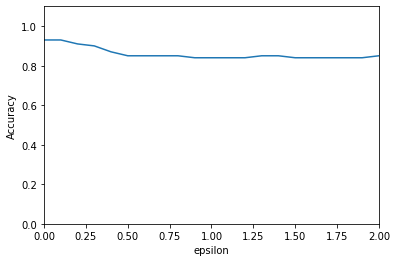

In [22]:
param = "epsilon"
param_range = (0, 2)
step_size = 0.1
param_values, all_scores = mean_evaluator.metric_vs_strength(param, param_range, step_size, adversarial_accuracy, adversarial=True)
fig = plot_change(param_values, all_scores, xlabel=param, ylabel="Accuracy", x_range=param_range, y_range=(0, 1.1), y_ticks=y_ticks)

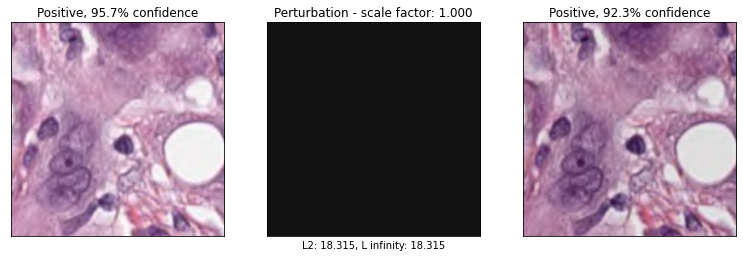

In [23]:
inputs, adv_inputs = mean_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(input_, adv_inputs[i], classes)